# Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle
import time
plt.viridis()
%matplotlib inline


def lorentzian(Img, s = 50):
    return np.log(1.0 + s * Img**2)

def lorentzianLoss(Img, Ground, s = 50): 
    tImg = Img - Ground; 
    tImg -= np.mean(tImg); 
    return np.mean(np.log(1.0 + s*(tImg)**2))

def getVal(default):
    r = input().strip()
    if r == '':
        return default
    else:
        return r

In [2]:
def getScenes(fname):
    if (fname.find("rain") > 0):
        print("Training data is taboo for baseline approach! Returning scenes anyway. ")
        scenes = [line.strip() for line in open(dataPath + "train.txt", 'r')]
    elif (fname.find("rueT") > 0):
        scenes = [line.strip() for line in open(dataPath + "trueTest.txt", 'r')]
    elif (fname.find("est") > 0): 
        scenes = [line.strip() for line in open(dataPath + "test.txt", 'r')]
    else: 
        print("Either validation set or test set should be chosen.")
        raise ValueError("Noncompliant input: must be \"Test\" or \"TrueTest\"") 
    print("%i scenes"%len(scenes))
    return scenes; 

def loadScene(sceneName): 
    GT = np.loadtxt("%s/labels/%s.dlm"%(dataPath, sceneName), delimiter='\t') # Get GT from data folder
    # GT DONE
    allInputRTF = np.loadtxt("%s/images/%s.dlm"%(dataPath, sceneName), delimiter='\t') # Get INPT from data folder
    formula = allInputRTF[:, 8:1800:9]
    C0 = allInputRTF[:, 0:1800:9]
    C1 = allInputRTF[:, 1:1800:9]
    C2 = allInputRTF[:, 2:1800:9]
    C3 = allInputRTF[:, 3:1800:9]
    # INPUT DONE
    return GT, formula, C0, C1, C2, C3

In [3]:
def evaluateScenes(weight, sceneSet):
    totVarLoss = [];
    formLoss = []; 
    for scene in sceneSet:
        gt, formula, C0, C1, C2, C3 = loadScene(scene); 
        formLoss.append(lorentzianLoss(gt, formula));
        Dd = denoise_tv_chambolle(formula, weight, multichannel=False)
        totVarLoss.append(lorentzianLoss(Dd, gt)); 
    #    print(LorentzianLoss(Dd, gt)); 
    print("Result for weight %f : %f"%(weight, np.mean(totVarLoss))); 
    return np.mean(totVarLoss)

# Little dataset. Can store all results in memory
def totVarApplication(weights, sceneSet):
    grid = np.zeros((len(weights), 2)); 
    grid[:, 0] = weights
    G = np.ndarray((200, 200, len(sceneSet))); 
    D = G.copy(); 
    i = 0; 
    for scene in sceneSet: 
        gt, formula, C0, C1, C2, C3 = loadScene(scene); 
        G[:,:,i] = gt; 
        D[:,:,i] = formula; 
        i += 1; 
    
    print("Data loaded. (%s passed)"%(time.time() - t))
    for i in range(len(weights)):
        currLoss = 0.0; 
        for j in range(len(sceneSet)): 
            Dc = D[:,:,j]; 
            gt = G[:,:,j]; 
            Dd = denoise_tv_chambolle(Dc, weights[i], multichannel=False)
            currLoss += lorentzianLoss(Dd, gt); 
        grid[i, 1] =  currLoss/len(sceneSet); 
        print("Result for weight %f : %f"%(weights[i], grid[i,1])); 
    return grid; 

def totVarApplication_OLD(weights, sceneSet): 
    grid = np.zeros((len(weights), 2))
    grid[:, 0] = weights
    for i in range(len(weights)): 
        grid[i, 1] = evaluateScenes(weights[i], sceneSet)
        print("Result for weight %f : %f"%(weights[i], grid[i,1])); 
    return grid

def determineSetLoss(sceneSet): 
    loss = []; 
    for scene in sceneSet:
        gt, formula, C0, C1, C2, C3 = loadScene(scene); 
        loss.append(lorentzianLoss(formula, gt)); 
    return np.mean(loss); 

In [4]:
def visualizeResults(weight, scene): 
    gt, formula, C0, C1, C2, C3 = loadScene(scene);
    inLoss = lorentzianLoss(formula, gt); 
    Dd = denoise_tv_chambolle(formula, weight, multichannel=False); 
    outLoss = lorentzianLoss(Dd, gt); 
    print("Loss before: @%f\t after: @%f"%(inLoss, outLoss)); 
    plt.figure(figsize=(14,3)); 
    plt.subplot(131); plt.imshow(formula); plt.axis('off'); plt.title("Baseline (%s)"%float('%.5g'%(inLoss))); plt.colorbar(); 
    plt.subplot(132); plt.imshow(Dd); plt.axis('off'); plt.title("Total Variation %s (%s)"%(float('%.3g'%(weight)), float('%.5g'%(outLoss)))); plt.colorbar(); 
    plt.subplot(133); plt.imshow(gt); plt.axis('off'); plt.title("Ground Truth %s"%scene); plt.colorbar(); 
    plt.show()

# Setup

In [5]:
print("Please enter path to data: ")
dataPath = getVal("depth_data/ToF-data/wholeset/")

validationScenes  = getScenes("Test")
testScenes = getScenes("TrueTest")

Please enter path to data: 

21 scenes
51 scenes


In [6]:
#validationLoss = determineSetLoss(validationScenes)
validationLoss = 0.411809737421
#testLoss = determineSetLoss(testScenes)
testLoss = 0.409037355913

# DENOISING PART

# Calibrate TV parameter on validation set

In [7]:
minWeight        = 0.001; 
maxWeight        = 0.4; 
step             = 0.01; # checked stepsize 0.001, value is solid 0.125. Curious jump when moving to 0.126 though
weightRange     = np.arange(minWeight, maxWeight, step);
#totalFormLoss   = []; 

t = time.time()
print("Loss before: @%s\n\n"%validationLoss)
lossTV = totVarApplication(weightRange, validationScenes); 

print("DONE")
print("(after %f s)"%(time.time() - t)); 

Loss before: @0.411809737421


Data loaded. (4.4448065757751465 passed)
Result for weight 0.001000 : 0.411380
Result for weight 0.011000 : 0.408859
Result for weight 0.021000 : 0.407303
Result for weight 0.031000 : 0.406119
Result for weight 0.041000 : 0.405285
Result for weight 0.051000 : 0.404789
Result for weight 0.061000 : 0.403938
Result for weight 0.071000 : 0.403321
Result for weight 0.081000 : 0.402887
Result for weight 0.091000 : 0.402941
Result for weight 0.101000 : 0.402297
Result for weight 0.111000 : 0.402122
Result for weight 0.121000 : 0.401601
Result for weight 0.131000 : 0.402124
Result for weight 0.141000 : 0.402067
Result for weight 0.151000 : 0.401791
Result for weight 0.161000 : 0.401985
Result for weight 0.171000 : 0.402230
Result for weight 0.181000 : 0.402443
Result for weight 0.191000 : 0.403474
Result for weight 0.201000 : 0.403556
Result for weight 0.211000 : 0.403831
Result for weight 0.221000 : 0.404084
Result for weight 0.231000 : 0.404248
Result for weigh

In [9]:
print("==========\nOLD METHOD\n==========")
t = time.time()
print("Loss before: @%s\n\n"%validationLoss)
lossTV = totVarApplication_OLD(weightRange, validationScenes); 

print("DONE")
print("(after %f s)"%(time.time() - t)); 

OLD METHOD
Loss before: @0.411809737421


Result for weight 0.001000 : 0.411380
Result for weight 0.001000 : 0.411380
Result for weight 0.011000 : 0.408859
Result for weight 0.011000 : 0.408859
Result for weight 0.021000 : 0.407303
Result for weight 0.021000 : 0.407303
Result for weight 0.031000 : 0.406119
Result for weight 0.031000 : 0.406119
Result for weight 0.041000 : 0.405285
Result for weight 0.041000 : 0.405285
Result for weight 0.051000 : 0.404789
Result for weight 0.051000 : 0.404789
Result for weight 0.061000 : 0.403938
Result for weight 0.061000 : 0.403938
Result for weight 0.071000 : 0.403321
Result for weight 0.071000 : 0.403321
Result for weight 0.081000 : 0.402887
Result for weight 0.081000 : 0.402887
Result for weight 0.091000 : 0.402941
Result for weight 0.091000 : 0.402941
Result for weight 0.101000 : 0.402297
Result for weight 0.101000 : 0.402297
Result for weight 0.111000 : 0.402122
Result for weight 0.111000 : 0.402122
Result for weight 0.121000 : 0.401601
Result f

In [8]:
#lossTV
print("Minimum loss @%s using filter value %f"%(np.min(lossTV[:,1]), weightRange[np.argmin(lossTV[:,1])]))

Minimum loss @0.401600729016 using filter value 0.121000


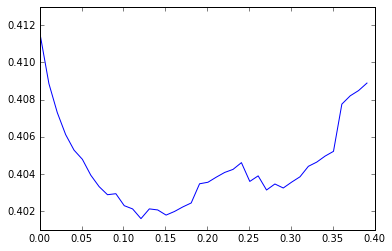

In [10]:
plt.plot(lossTV[:,0], lossTV[:, 1]); 
plt.ylim([0.401, 0.413]); 
plt.show()

In [ ]:
print("Choose filter value? [0.125]")
weight = float(getVal("0.125"))
print("How many random scenes should be chosen for display? [4]")
n = int(getVal("4"))
for scene in np.random.permutation(validationScenes)[0:int(n)]:
    visualizeResults(weight, scene);   

# Evaluate TV denoising performance on testset

In [ ]:
print("Choose filter value? [0.125]")
weight = float(getVal("0.125"))


t = time.time()
print("Loss before: @%s"%testLoss)
lossTVtest = totVarApplication(np.arange(weight, weight+0.1, 1), testScenes); 
print("Loss after: @%s"%lossTVtest[0, 1])
print("DONE")
print("(after %f s)"%(time.time() - t)); 

In [ ]:
print("How many random scenes should be chosen for display? [3]")
n = int(getVal("3"))
for scene in np.random.permutation(testScenes)[0:int(n)]:
    visualizeResults(weight, scene);   